In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
from PIL import Image


In [ ]:
# Define ConvNet3 and ConvNet7 Models
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

class ConvNet7(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Import Libraries and Define Data Transformations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# File Upload and Extraction
#  Make sure the ZIP file has been uploaded to images.zip under the /content/mhist_dataset folder
mhist_zip_path = '/content/mhist_dataset/images.zip'
mhist_extract_path = '/content/mhist_dataset/images'
# unzip MHIST ZIP file
with zipfile.ZipFile(mhist_zip_path, 'r') as zip_ref:
    zip_ref.extractall(mhist_extract_path)


In [ ]:
#Load MNIST Dataset for Standard Training
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

train_loader_mnist = DataLoader(mnist_dataset, batch_size=256, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=256, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 430kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.00MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Custom MHIST data set classes
class MHISTDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_text = self.img_labels.iloc[idx, 1]
        # Convert labels to integers 'HP' -> 0, 'SSA' -> 1
        if label_text == 'HP':
            label = 0
        elif label_text == 'SSA':
            label = 1
        else:
            raise ValueError(f"Unexpected label value: {label_text}")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# MHIST data set path
annotations_file = '/content/mhist_dataset/annotations.csv'
img_dir = '/content/mhist_dataset/images/images'

In [ ]:
# Set up preprocessing of MHIST data sets
mhist_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Suitable for single-channel grayscale images
])

In [ ]:
# Load the MHIST data set
mhist_dataset = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
train_loader_mhist = DataLoader(mhist_dataset, batch_size=128, shuffle=True)

In [ ]:
# Define Model, Loss, and Optimizer for Standard Training
model_mnist = ConvNet3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_mnist = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9)

# Train the model on full dataset
def train_model(model, data_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            except Exception as e:
                continue

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(data_loader)}")

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")
# For MNIST
train_model(model_mnist, train_loader_mnist, criterion, optimizer_mnist, epochs=20)
evaluate_model(model_mnist, test_loader_mnist)

Epoch 1/20, Loss: 0.38628806681074995
Epoch 2/20, Loss: 0.10596167250992136
Epoch 3/20, Loss: 0.07172348202067487
Epoch 4/20, Loss: 0.059157884124904234
Epoch 5/20, Loss: 0.04938635293869896
Epoch 6/20, Loss: 0.04524999130913552
Epoch 7/20, Loss: 0.04037961067354425
Epoch 8/20, Loss: 0.036359604354947804
Epoch 9/20, Loss: 0.03221580803572656
Epoch 10/20, Loss: 0.029481215825542174
Epoch 11/20, Loss: 0.0274418665532102
Epoch 12/20, Loss: 0.024408989749412906
Epoch 13/20, Loss: 0.021954453821749764
Epoch 14/20, Loss: 0.02019625455339221
Epoch 15/20, Loss: 0.01841402786407382
Epoch 16/20, Loss: 0.016120270455374997
Epoch 17/20, Loss: 0.015017055652718594
Epoch 18/20, Loss: 0.013294779511287491
Epoch 19/20, Loss: 0.012989685234138147
Epoch 20/20, Loss: 0.011565992480857257
Test Accuracy: 98.39%


In [ ]:
# Train ConvNet-7 on MHIST Dataset
model_mhist = ConvNet7().to(device)
optimizer_mhist = optim.SGD(model_mhist.parameters(), lr=0.01, momentum=0.9)

train_model(model_mhist, train_loader_mhist, criterion, optimizer_mhist, epochs=20)
evaluate_model(model_mhist, train_loader_mhist)

Epoch 1/20, Loss: 0.6353574776649475
Epoch 2/20, Loss: 0.6095033144950867
Epoch 3/20, Loss: 0.5861008203029633
Epoch 4/20, Loss: 0.5759060668945313
Epoch 5/20, Loss: 0.5436980748176574
Epoch 6/20, Loss: 0.5097814762592315
Epoch 7/20, Loss: 0.49354797720909116
Epoch 8/20, Loss: 0.4806488370895386
Epoch 9/20, Loss: 0.470728805065155
Epoch 10/20, Loss: 0.4637076282501221
Epoch 11/20, Loss: 0.4491611325740814
Epoch 12/20, Loss: 0.4270461857318878
Epoch 13/20, Loss: 0.4210186207294464
Epoch 14/20, Loss: 0.40984813213348387
Epoch 15/20, Loss: 0.39449386596679686
Epoch 16/20, Loss: 0.3647758162021637
Epoch 17/20, Loss: 0.355795601606369
Epoch 18/20, Loss: 0.3244953829050064
Epoch 19/20, Loss: 0.29357535362243653
Epoch 20/20, Loss: 0.2643807780742645
Test Accuracy: 92.95685279187818%


In [ ]:
pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=d6fcd18f8805718ba452aa3297200879d0d48065a3e27bb4d3b3520e8a1d8a47
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=288ceec8aa0980b2910b23558c73936147011975def735701c1bf663bd9fd994
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis
import torch



model_convnet3 = ConvNet3().to(device)
model_convnet7 = ConvNet7().to(device)

# FLOPs
input_tensor = torch.randn(1, 1, 28, 28).to(device)
flop_counter_convnet3 = FlopCountAnalysis(model_convnet3, input_tensor)
print(f"ConvNet3 FLOPs: {flop_counter_convnet3.total()}")

flop_counter_convnet7 = FlopCountAnalysis(model_convnet7, input_tensor)
print(f"ConvNet7 FLOPs: {flop_counter_convnet7.total()}")


ConvNet3 FLOPs: 3976448
ConvNet7 FLOPs: 392226816


In [ ]:
######################
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Initializing distillation images from real data
def initialize_from_real_data(data_loader, num_classes, num_images_per_class):
    """
    从真实数据集中随机选择每个类别的图像来初始化蒸馏图像。
    """
    real_images = []
    real_labels = []
    for class_idx in range(num_classes):
        count = 0
        for images, labels in data_loader:
            mask = (labels == class_idx)
            selected_images = images[mask]
            if selected_images.size(0) > 0:
                real_images.append(selected_images[:num_images_per_class])
                real_labels.extend([class_idx] * min(num_images_per_class, selected_images.size(0)))
                count += selected_images.size(0)
            if count >= num_images_per_class:
                break
    real_images = torch.cat(real_images).to(device)
    real_labels = torch.tensor(real_labels).to(device)
    return real_images, real_labels

# Initialize the distillation image and label for MHIST
num_classes = 2  # Suppose that MHIST is a binary classification problem
num_images_per_class = 10  # The number of distilled images per category
distilled_images, distilled_labels = initialize_from_real_data(train_loader_mhist, num_classes, num_images_per_class)
distilled_images.requires_grad = True
lr_image = 0.1  # Learning rate of distillation image
optimizer_images = optim.SGD([distilled_images], lr=lr_image)

In [ ]:
# Initialize the distillation image and label for MNIST
num_classes_MNIST = 10 #0-9
distilled_images_MNIST, distilled_labels_MNIST = initialize_from_real_data(train_loader_mnist, num_classes_MNIST, num_images_per_class)
distilled_images.requires_grad = True
optimizer_images_MNIST = optim.SGD([distilled_images_MNIST], lr=lr_image)

In [ ]:
# Data distillation using Attention Matching
def distill_with_attention_matching(model, data_loader, distilled_images, distilled_labels, optimizer_images, T=10):
    """
    Data distillation based on Attention Matching.
    Parameter:
        model: torch.nn.Module
        data_loader: DataLoader
        distilled_images: torch.Tensor
        distilled_labels: torch.Tensor
        optimizer_images: torch.optim.Optimizer
        T: int
    """
    model.eval()
    for t in range(T):
        total_loss = 0.0
        for real_images, real_labels in data_loader:
            real_images, real_labels = real_images.to(device), real_labels.to(device)

            optimizer_images.zero_grad()
            with torch.no_grad():
                real_outputs = model(real_images)
                real_loss = F.cross_entropy(real_outputs, real_labels)

            synthetic_outputs = model(distilled_images)
            synthetic_loss = F.cross_entropy(synthetic_outputs, distilled_labels)
            synthetic_loss.backward()
            optimizer_images.step()

            total_loss += synthetic_loss.item()

        print(f"iter {t+1}/{T}, Distillation loss: {total_loss / len(data_loader)}")

# Data distillation for MHIST
T = 10
distill_with_attention_matching(model_mhist, train_loader_mhist, distilled_images, distilled_labels, optimizer_images, T=T)

iter 1/10, Distillation loss: 0.12815088421106338
iter 2/10, Distillation loss: 0.08125486254692077
iter 3/10, Distillation loss: 0.061924075931310656
iter 4/10, Distillation loss: 0.05106198936700821
iter 5/10, Distillation loss: 0.04391223177313805
iter 6/10, Distillation loss: 0.038827843964099884
iter 7/10, Distillation loss: 0.034952007383108136
iter 8/10, Distillation loss: 0.03178262040019035
iter 9/10, Distillation loss: 0.02919516332447529
iter 10/10, Distillation loss: 0.02705201655626297


In [ ]:
# Data distillation for MNIST
distill_with_attention_matching(model_mnist, train_loader_mnist, distilled_images_MNIST, distilled_labels_MNIST, optimizer_images_MNIST, T=T)

iter 1/10, Distillation loss: 0.018182702362537384
iter 2/10, Distillation loss: 0.018182702362537384
iter 3/10, Distillation loss: 0.018182702362537384
iter 4/10, Distillation loss: 0.018182702362537384
iter 5/10, Distillation loss: 0.018182702362537384
iter 6/10, Distillation loss: 0.018182702362537384
iter 7/10, Distillation loss: 0.018182702362537384
iter 8/10, Distillation loss: 0.018182702362537384
iter 9/10, Distillation loss: 0.018182702362537384
iter 10/10, Distillation loss: 0.018182702362537384


In [ ]:
# Retrain the model on the distillation data set
def train_on_distilled_data(model, distilled_images, distilled_labels, epochs=20, lr=0.01):
    distilled_dataset = TensorDataset(distilled_images, distilled_labels)
    distilled_loader = DataLoader(distilled_dataset, batch_size=32, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in distilled_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(distilled_loader)}")

# Retrain the model on the distillation data set FOR MHIST
model_mhist = ConvNet7().to(device)
train_on_distilled_data(model_mhist, distilled_images, distilled_labels, epochs=20, lr=0.01)

Epoch 1/20, Loss: 0.6939924359321594
Epoch 2/20, Loss: 0.6892452239990234
Epoch 3/20, Loss: 0.6852076649665833
Epoch 4/20, Loss: 0.6815016269683838
Epoch 5/20, Loss: 0.6780368089675903
Epoch 6/20, Loss: 0.6746540665626526
Epoch 7/20, Loss: 0.6712791919708252
Epoch 8/20, Loss: 0.6678932905197144
Epoch 9/20, Loss: 0.6644468307495117
Epoch 10/20, Loss: 0.6609519720077515
Epoch 11/20, Loss: 0.6574371457099915
Epoch 12/20, Loss: 0.6537200808525085
Epoch 13/20, Loss: 0.6498643159866333
Epoch 14/20, Loss: 0.6458966135978699
Epoch 15/20, Loss: 0.6417642831802368
Epoch 16/20, Loss: 0.6373794078826904
Epoch 17/20, Loss: 0.6329681277275085
Epoch 18/20, Loss: 0.6283397674560547
Epoch 19/20, Loss: 0.6235371828079224
Epoch 20/20, Loss: 0.6183923482894897


In [ ]:
# Retrain the model on the distillation data set FOR MNIST
model_mnist = ConvNet3().to(device)
train_on_distilled_data(model_mnist, distilled_images_MNIST, distilled_labels_MNIST, epochs=20, lr=0.01)

Epoch 1/20, Loss: 2.3597442507743835
Epoch 2/20, Loss: 2.3197710514068604
Epoch 3/20, Loss: 2.3003786206245422
Epoch 4/20, Loss: 2.248607039451599
Epoch 5/20, Loss: 2.1384817361831665
Epoch 6/20, Loss: 2.0711823105812073
Epoch 7/20, Loss: 2.0076796114444733
Epoch 8/20, Loss: 1.9104067087173462
Epoch 9/20, Loss: 1.901593178510666
Epoch 10/20, Loss: 1.7307570278644562
Epoch 11/20, Loss: 1.5764578580856323
Epoch 12/20, Loss: 1.4684158861637115
Epoch 13/20, Loss: 1.308501660823822
Epoch 14/20, Loss: 1.2460057437419891
Epoch 15/20, Loss: 1.0612951517105103
Epoch 16/20, Loss: 1.0062568932771683
Epoch 17/20, Loss: 0.9846598505973816
Epoch 18/20, Loss: 0.7429331690073013
Epoch 19/20, Loss: 0.6779633462429047
Epoch 20/20, Loss: 0.686109259724617


In [ ]:
# Evaluate model performance on a real-world test set
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on a real test set: {100 * correct / total}%")


test_dataset_mhist = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
test_loader_mhist = DataLoader(test_dataset_mhist, batch_size=128, shuffle=False)
# Evaluate the model using test sets for MHIST
evaluate_model(model_mhist, test_loader_mhist)


Accuracy on a real test set: 52.66497461928934%


In [ ]:
# Evaluate the model using test sets for MNIST
evaluate_model(model_mnist, test_loader_mnist)

Accuracy on a real test set: 65.47%


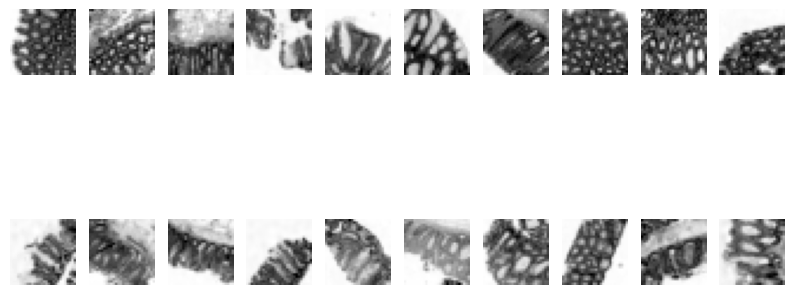

In [ ]:
import matplotlib.pyplot as plt

# Displays distillation images for each category
def visualize_distilled_images(distilled_images, num_classes, num_images_per_class):
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(10, 5))
    for class_idx in range(num_classes):
        for img_idx in range(num_images_per_class):
            ax = axes[class_idx, img_idx]
            # The gradient is separated using.detach(), converted to CPU and converted to numpy format
            ax.imshow(distilled_images[class_idx * num_images_per_class + img_idx].cpu().detach().squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

# Visualize the distillation data set generated by steps 1 and 2
# For MHIST
visualize_distilled_images(distilled_images, num_classes=2, num_images_per_class=num_images_per_class)




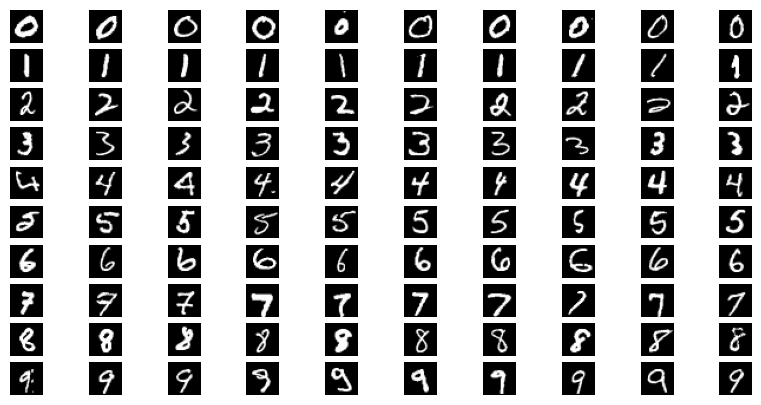

In [ ]:
#For MNIST
visualize_distilled_images(distilled_images_MNIST, num_classes=10, num_images_per_class=num_images_per_class)

iter 1/10, Distillation loss: 0.693043692111969
iter 2/10, Distillation loss: 0.6930108022689819
iter 3/10, Distillation loss: 0.6929756879806519
iter 4/10, Distillation loss: 0.6929416799545288
iter 5/10, Distillation loss: 0.6929089403152466
iter 6/10, Distillation loss: 0.6928750658035279
iter 7/10, Distillation loss: 0.6928419804573059
iter 8/10, Distillation loss: 0.6928086471557617
iter 9/10, Distillation loss: 0.6927750110626221
iter 10/10, Distillation loss: 0.6927416086196899
Epoch 1/20, Loss: 0.6949266195297241
Epoch 2/20, Loss: 0.6777883768081665
Epoch 3/20, Loss: 0.6633500456809998
Epoch 4/20, Loss: 0.6496861577033997
Epoch 5/20, Loss: 0.635501503944397
Epoch 6/20, Loss: 0.620994508266449
Epoch 7/20, Loss: 0.6059054136276245
Epoch 8/20, Loss: 0.5906845331192017
Epoch 9/20, Loss: 0.5753730535507202
Epoch 10/20, Loss: 0.5600945949554443
Epoch 11/20, Loss: 0.5439456105232239
Epoch 12/20, Loss: 0.5273260474205017
Epoch 13/20, Loss: 0.51065593957901
Epoch 14/20, Loss: 0.49388360

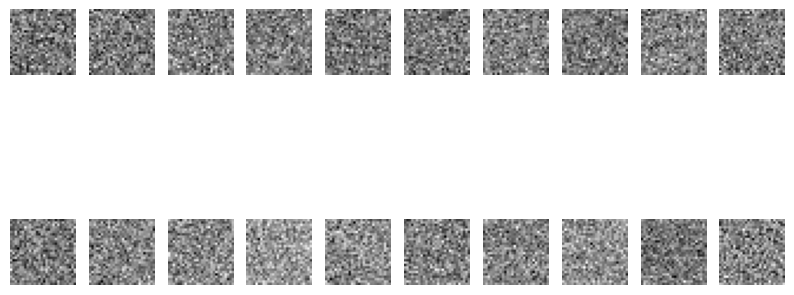

In [ ]:
# The distillation image is initialized with Gaussian noise and the distillation is started from scratch
# Gaussian noise initialization was used for comparative experiments
distilled_images_gaussian = torch.randn((2 * num_images_per_class, 1, 28, 28), requires_grad=True, device=device)
distilled_labels_gaussian = torch.tensor([0] * num_images_per_class + [1] * num_images_per_class).to(device)
optimizer_images_gaussian = optim.SGD([distilled_images_gaussian], lr=lr_image)  # Use the same learning rate

# Rerun the distillation process, starting from scratch
T_gaussian = 10
distill_with_attention_matching(model_mhist, train_loader_mhist, distilled_images_gaussian, distilled_labels_gaussian, optimizer_images_gaussian, T=T_gaussian)

# Retrain the model on the distillation data set
model_mhist_gaussian = ConvNet7().to(device)  # Reinitialize the model, making sure to start from scratch
train_on_distilled_data(model_mhist_gaussian, distilled_images_gaussian, distilled_labels_gaussian, epochs=20, lr=0.01)

# Define the DataLoader for the MHIST test set
test_dataset_mhist = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
test_loader_mhist = DataLoader(test_dataset_mhist, batch_size=128, shuffle=False)

# Evaluate
evaluate_model(model_mhist_gaussian, test_loader_mhist)


# Visualize distillation data initialized with Gaussian noise
visualize_distilled_images(distilled_images_gaussian, num_classes, num_images_per_class)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Defining new network architectures LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training LeNet models using synthetic data sets
def train_on_distilled_data_leNet(model, distilled_images, distilled_labels, epochs=20, lr=0.01):
    distilled_dataset = TensorDataset(distilled_images, distilled_labels)
    distilled_loader = DataLoader(distilled_dataset, batch_size=32, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in distilled_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(distilled_loader)}")

# Initialize and train the LeNet model
model_leNet = LeNet().to(device)
train_on_distilled_data_leNet(model_leNet, distilled_images, distilled_labels, epochs=20, lr=0.01)

# Evaluate the LeNet model on a real test set
evaluate_model(model_leNet, test_loader_mhist)


Epoch 1/20, Loss: 2.2556214332580566
Epoch 2/20, Loss: 2.2490291595458984
Epoch 3/20, Loss: 2.242401599884033
Epoch 4/20, Loss: 2.235717296600342
Epoch 5/20, Loss: 2.2290689945220947
Epoch 6/20, Loss: 2.2223877906799316
Epoch 7/20, Loss: 2.2157039642333984
Epoch 8/20, Loss: 2.209005832672119
Epoch 9/20, Loss: 2.202366590499878
Epoch 10/20, Loss: 2.195761203765869
Epoch 11/20, Loss: 2.189135789871216
Epoch 12/20, Loss: 2.1824707984924316
Epoch 13/20, Loss: 2.1758241653442383
Epoch 14/20, Loss: 2.169132709503174
Epoch 15/20, Loss: 2.1623597145080566
Epoch 16/20, Loss: 2.155492067337036
Epoch 17/20, Loss: 2.148563861846924
Epoch 18/20, Loss: 2.1415820121765137
Epoch 19/20, Loss: 2.134524345397949
Epoch 20/20, Loss: 2.1273608207702637
Accuracy on a real test set: 68.59137055837563%
